### Применение TSLearn к анализу временной серии

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.datasets import CachedDatasets

In [203]:
from load_csv import df
# clear all indexes
df = df.reset_index(drop=True)
df1 = df[['Date','Infections']]
df1.reset_index(drop=True)
df1['Inf_day'] = df1['Infections'].diff().fillna(df1['Infections'])
l = df1['Date']
ts = df1['Inf_day']
data = ts.values
X = data.reshape(data.shape[0])
print(X)


[ 6.  0.  3. ... 23. 11. 27.]


C:\Users\Alex\AppData\Local\Temp\ipykernel_64768\3674077191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Inf_day'] = df1['Infections'].diff().fillna(df1['Infections'])


In [204]:
# Normalize the data
import matplotlib.pyplot as plt
# Normalize the data
scaler = TimeSeriesScalerMeanVariance()
X_normalized = scaler.fit_transform([X])

X_n = X_normalized[0]
                                    
print(X_n)
#plt.plot(X_normalized)тся


[[-0.7141232 ]
 [-0.75404669]
 [-0.73408494]
 ...
 [-0.60100664]
 [-0.68085362]
 [-0.57439098]]


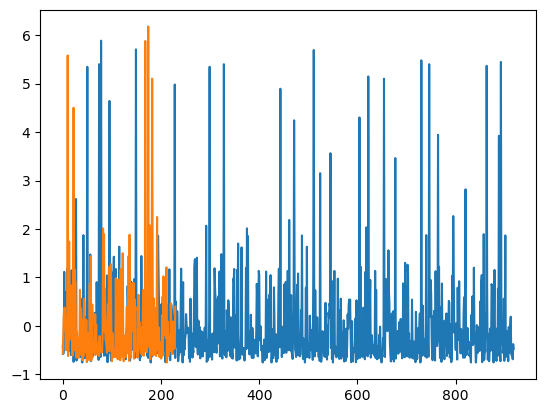

In [205]:
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_n, X_n, test_size=0.2, random_state=42)
plt.plot(X_train)
plt.plot(X_test)


In [206]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Set the number of units 20 - 100
UNITS = 100

# Build the GRU model
model = Sequential()
model.add(GRU(units=UNITS, activation='relu', input_shape=(X_normalized.shape[1], X_normalized.shape[2])))
model.add(Dense(1))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

In [207]:
EPOCHS = 100
BATCH_SIZE = 30

# Train the model
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 0.7250 - val_loss: 0.5832
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 0.4173 - val_loss: 0.3136
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 0.1956 - val_loss: 0.1094
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0253
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0083
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.0044e-04
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 7.2643e-04 - val_loss: 4.8172e

In [208]:
# Make predictions on the entire dataset
print(X_n)


[[-0.7141232 ]
 [-0.75404669]
 [-0.73408494]
 ...
 [-0.60100664]
 [-0.68085362]
 [-0.57439098]]


In [209]:
# y_pred = model.predict(X_n.reshape(X_n.shape[0], X_n.shape[1], 1))
y_pred = model.predict(X_n)
# Print the predictions

print(y_pred)

36/36 [==============================] - 0s 826us/step
[[-0.7121207 ]
 [-0.75117373]
 [-0.7316561 ]
 ...
 [-0.60108835]
 [-0.67952263]
 [-0.5748815 ]]


In [210]:
from sklearn.metrics import mean_squared_error
# Calculate Mean Squared Error (MSE) as a performance metric
mse = mean_squared_error(X_n, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9.623768707018747e-06


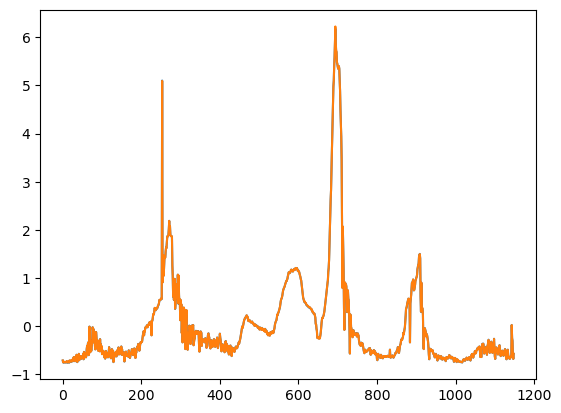

In [211]:
plt.plot(X_n)
plt.plot(y_pred)

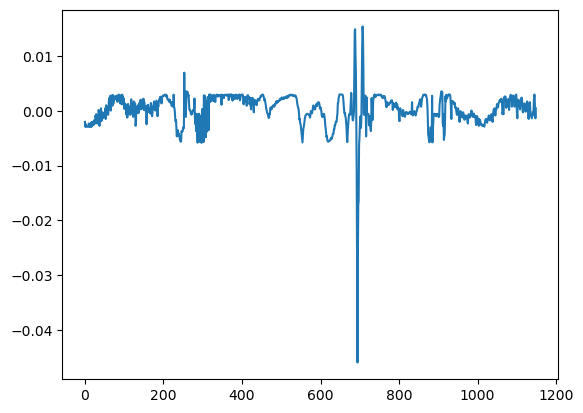

In [212]:
plt.plot(X_n-y_pred)

In [213]:
# Calculate mean and variance for inverse scaling

mu = np.mean(X)
var = np.var(X)
print(mu,var)

113.32375979112271 22586.319896742993


In [214]:
# Inverse transform predictions to get them in their original scale
y_pred_original_scale = (y_pred * np.sqrt(var)) + mu

In [215]:
import pandas as pd
df_gru = pd.DataFrame()

df_gru['X'] = X

df_gru['y_pred_original_scale'] = y_pred_original_scale

df_gru['Err'] = df_gru['y_pred_original_scale'] - df_gru['X']

df_gru['Err_Sqr'] = df_gru['Err']**2

MSE = df_gru['Err_Sqr'].sum() / len(df_gru)

print(df_gru)
print(MSE)



         X  y_pred_original_scale       Err   Err_Sqr
0      6.0               6.300949  0.300949  0.090570
1      0.0               0.431770  0.431770  0.186426
2      3.0               3.365028  0.365028  0.133246
3      0.0               0.431770  0.431770  0.186426
4      0.0               0.431770  0.431770  0.186426
...    ...                    ...       ...       ...
1144  76.0              75.547844 -0.452156  0.204445
1145  68.0              67.562820 -0.437180  0.191126
1146  23.0              22.987717 -0.012283  0.000151
1147  11.0              11.200027  0.200027  0.040011
1148  27.0              26.926285 -0.073715  0.005434

[1149 rows x 4 columns]
0.21736558561016603


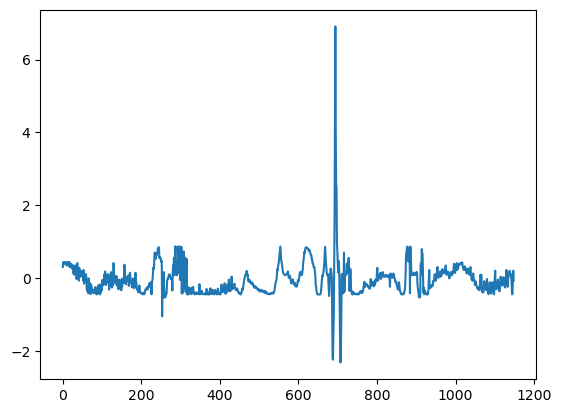

In [216]:
plt.plot(df_gru['Err'])

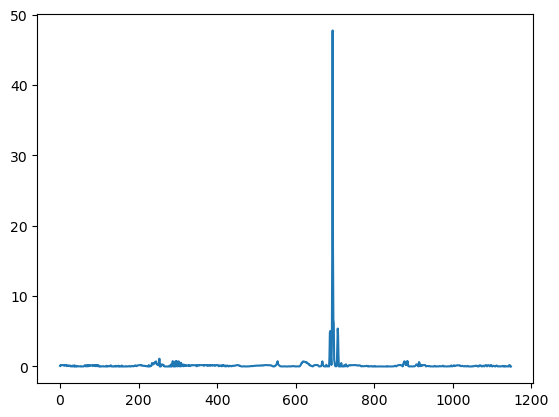

In [217]:
plt.plot(df_gru['Err_Sqr'])

(array([6.000e+00, 1.500e+01, 1.033e+03, 8.900e+01, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.32141113, -1.39821777, -0.47502441,  0.44816895,  1.3713623 ,
         2.29455566,  3.21774902,  4.14094238,  5.06413574,  5.9873291 ,
         6.91052246]),
 <BarContainer object of 10 artists>)

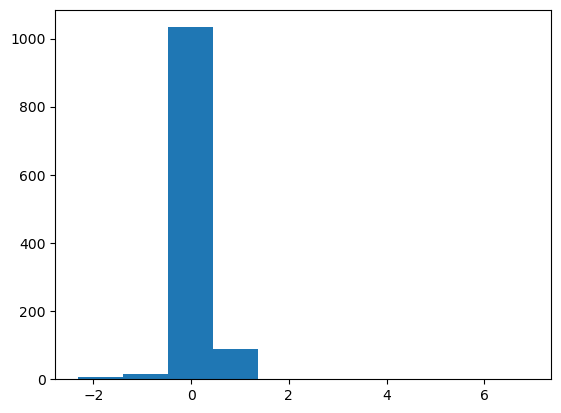

In [218]:
plt.hist(df_gru['Err'])

In [219]:
from keras.models import save_model

# Save the model to a file
model.save("my_gru_model.h5")
